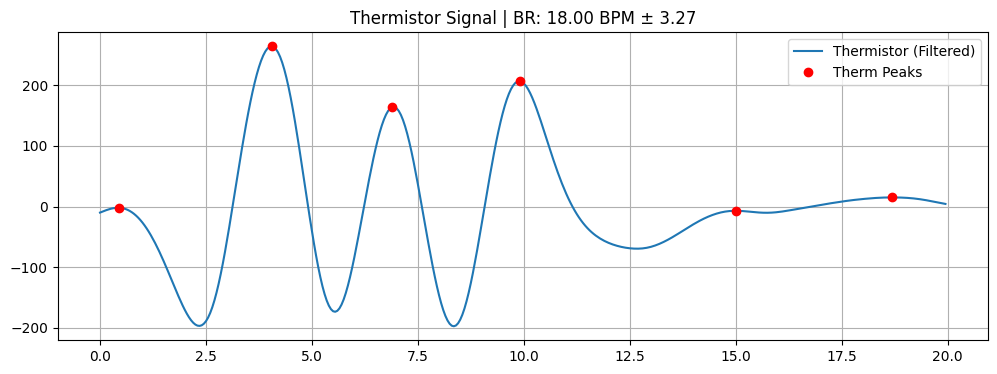

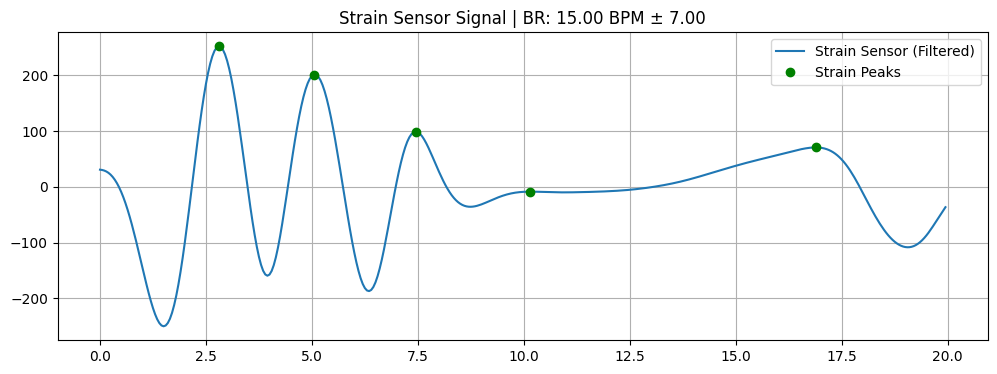

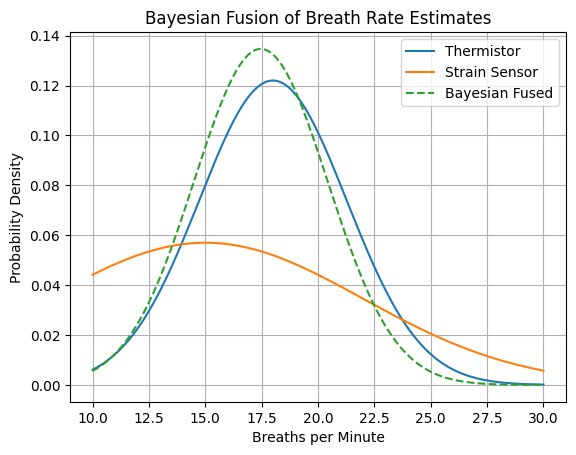

Thermistor Estimate: 18.00 ± 3.27 BPM
Strain Estimate:    15.00 ± 7.00 BPM
Bayesian Fused:     17.46 ± 2.96 BPM


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.stats import norm

# --------------------
# CONFIG
# --------------------
fs = 20  # sampling rate in Hz
min_breath_interval = 2  # in seconds
interval_sec = 1 / fs    # 0.05s per sample

# --------------------
# 1. Load Data
# --------------------
def load_adc_data(filepath):
    df = pd.read_csv(filepath)
    signal = df['ADC Value'].values
    time = np.arange(len(signal)) / fs  # create time vector from sample number
    return time, signal

# Load both sensor files
time_therm, signal_therm = load_adc_data('adc_data_1.csv')
time_strain, signal_strain = load_adc_data('adc_data_2.csv')

# --------------------
# 2. Bandpass Filter
# --------------------
def bandpass_filter(signal, fs, lowcut=0.1, highcut=0.5, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

signal_therm_filtered = bandpass_filter(signal_therm, fs)
signal_strain_filtered = bandpass_filter(signal_strain, fs)

# --------------------
# 3. Peak Detection
# --------------------
def detect_peaks(signal, fs):
    min_dist = int(min_breath_interval * fs)
    peaks, _ = find_peaks(signal, distance=min_dist)
    return peaks

peaks_therm = detect_peaks(signal_therm_filtered, fs)
peaks_strain = detect_peaks(signal_strain_filtered, fs)

# --------------------
# 4. Compute Breath Rate & Estimate Uncertainty
# --------------------
def compute_breath_rate(peaks, duration_sec):
    return (len(peaks) / duration_sec) * 60

duration_sec = len(signal_therm) / fs
br_therm = compute_breath_rate(peaks_therm, duration_sec)
br_strain = compute_breath_rate(peaks_strain, duration_sec)

def estimate_uncertainty(peaks, fs):
    if len(peaks) < 2:
        return 2.0
    intervals = np.diff(peaks) / fs
    br_estimates = 60.0 / intervals
    return np.std(br_estimates)

sigma_therm = estimate_uncertainty(peaks_therm, fs)
sigma_strain = estimate_uncertainty(peaks_strain, fs)

# --------------------
# 5. Bayesian Fusion
# --------------------
def bayesian_fusion(mu1, sigma1, mu2, sigma2):
    fused_mu = (mu1 / sigma1**2 + mu2 / sigma2**2) / (1 / sigma1**2 + 1 / sigma2**2)
    fused_sigma2 = 1 / (1 / sigma1**2 + 1 / sigma2**2)
    return fused_mu, np.sqrt(fused_sigma2)

br_fused, br_uncertainty = bayesian_fusion(br_therm, sigma_therm, br_strain, sigma_strain)

# --------------------
# 6. Plot Signals and Posterior
# --------------------
plt.figure(figsize=(12, 4))
plt.plot(time_therm, signal_therm_filtered, label='Thermistor (Filtered)')
plt.plot(time_therm[peaks_therm], signal_therm_filtered[peaks_therm], 'ro', label='Therm Peaks')
plt.title(f'Thermistor Signal | BR: {br_therm:.2f} BPM ± {sigma_therm:.2f}')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(time_strain, signal_strain_filtered, label='Strain Sensor (Filtered)')
plt.plot(time_strain[peaks_strain], signal_strain_filtered[peaks_strain], 'go', label='Strain Peaks')
plt.title(f'Strain Sensor Signal | BR: {br_strain:.2f} BPM ± {sigma_strain:.2f}')
plt.legend()
plt.grid()
plt.show()

x = np.linspace(10, 30, 500)
plt.plot(x, norm.pdf(x, br_therm, sigma_therm), label='Thermistor')
plt.plot(x, norm.pdf(x, br_strain, sigma_strain), label='Strain Sensor')
plt.plot(x, norm.pdf(x, br_fused, br_uncertainty), label='Bayesian Fused', linestyle='--')
plt.title('Bayesian Fusion of Breath Rate Estimates')
plt.xlabel('Breaths per Minute')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

# --------------------
# 7. Output Summary
# --------------------
print(f"Thermistor Estimate: {br_therm:.2f} ± {sigma_therm:.2f} BPM")
print(f"Strain Estimate:    {br_strain:.2f} ± {sigma_strain:.2f} BPM")
print(f"Bayesian Fused:     {br_fused:.2f} ± {br_uncertainty:.2f} BPM")
